In [1]:


# ===========================
#  Imports & Setup
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, f1_score, accuracy_score)

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

RS = 42

In [2]:
# ===========================
#  Load Data
# ===========================
df_encoded = pd.read_csv("./../data/df_encoded.csv")
print("Shape:", df_encoded.shape)

target = "PAY_AMT4"

X = df_encoded.drop(columns=[target, 'default_pnm',
                             'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4',
                             'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                             'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3'])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Target mean:", y.mean(), " | Nonzero %:", (y>0).mean())

Shape: (30000, 30)
Target mean: 4826.076866666666  | Nonzero %: 0.7864


In [3]:
X.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_5', 'PAY_6', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4'],
      dtype='object')

In [4]:
# ===========================
#  Helper Functions
# ===========================
def regression_metrics(y_true, y_pred):
    """Print regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    return mae, rmse, r2

def yreal_vs_ypred(y_true, y_pred, title="y_real vs y_pred"):
    """Scatter plot for true vs predicted."""
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.plot([0, max(y_true)], [0, max(y_true)], "r--")
    plt.show()

def evaluate_model(model, X_test, y_test):
    """Evaluate classification model with common metrics and plots."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("F1:", f1_score(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.show()

In [5]:
# ===========================
#  Preprocessing Pipeline
# ===========================


continuos_cols = ['LIMIT_BAL', 'AGE', 
                  'PAY_AMT5', 'BILL_AMT6',
                  'PAY_AMT6', 'PAY_AMT6']

scaler = ColumnTransformer(
    transformers=[('cont', StandardScaler(), continuos_cols)],
        remainder='passthrough'
)


Baseline Ridge Regression (no hurdle):
MAE: 4568.596 | RMSE: 11873.918 | R²: 0.139


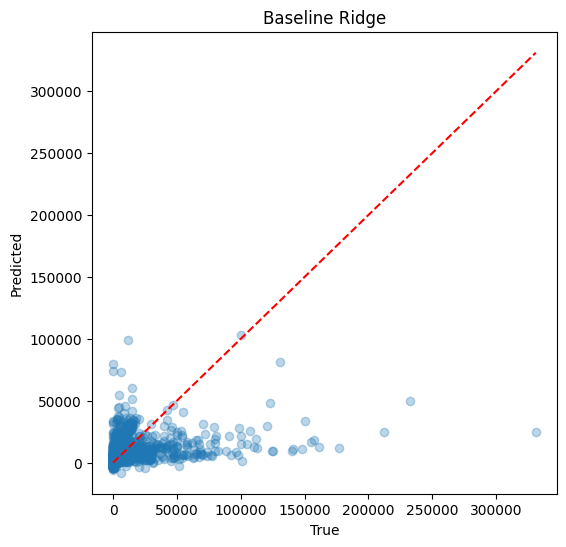

In [6]:
# ===========================
#  Baseline Ridge Regression (no hurdle)
# ===========================
ridge_pipe = Pipeline([
    ("scaler", scaler),
    ("ridge", Ridge(alpha=1.0))
])

ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)

print("Baseline Ridge Regression (no hurdle):")
regression_metrics(y_test, y_pred_ridge)
yreal_vs_ypred(y_test, y_pred_ridge, "Baseline Ridge")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params (LogReg): {'clf__C': 9.999999999999999e-05}
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.62      0.75      1254
           1       0.91      0.99      0.95      4746

    accuracy                           0.91      6000
   macro avg       0.93      0.81      0.85      6000
weighted avg       0.92      0.91      0.91      6000

ROC-AUC: 0.8577540492421722
F1: 0.9482793318575166
Accuracy: 0.9143333333333333


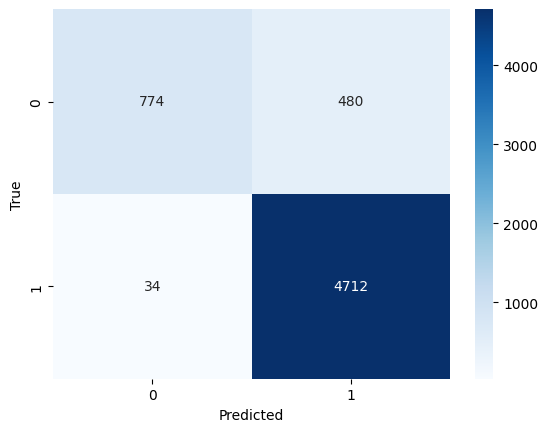

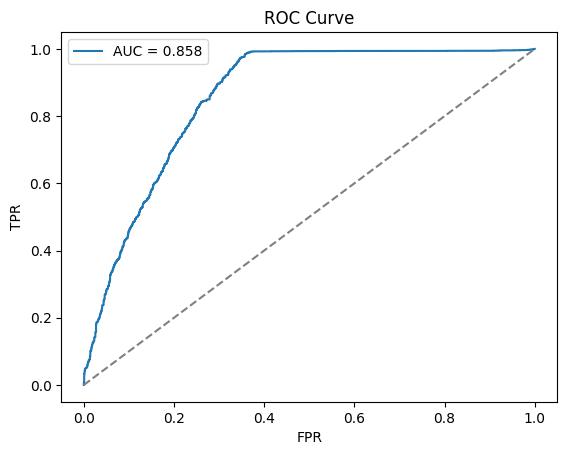

In [7]:
# ===========================
#  Hurdle Model Setup
# ===========================
#  Classification part (predict zero vs nonzero)
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

######################################

log_reg = Pipeline([
    ("scaler", scaler),
    ('smt', SMOTETomek(random_state=RS)),
    ("clf", LogisticRegression(penalty='l2', max_iter=1000, solver="liblinear"))
])

param_grid= {'clf__C': np.logspace(-4,0,5)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

grid_lr = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    cv=skf, 
    scoring="roc_auc", 
    n_jobs=7,
    verbose=1)

grid_lr.fit(X_train, y_train_class)

print("Best params (LogReg):", grid_lr.best_params_)
evaluate_model(grid_lr.best_estimator_, X_test, y_test_class)

In [8]:
# ===========================
#  Ridge Regression inside Hurdle
# ===========================
cont_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler())
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('cont', cont_pipeline, continuos_cols)],
        remainder='passthrough'
)

ridge_poly = Pipeline([
    ("pre", preprocessor_reg),
    ("ridge", Ridge())
])

param_grid_ridge = {
    "ridge__alpha": [0.1, 1.0, 10],
    'pre__cont__poly__degree':[1,2,3,4]
}

grid_ridge = GridSearchCV(
    ridge_poly, 
    param_grid_ridge, 
    cv=3, 
    scoring="neg_mean_absolute_error",
    verbose=1,
    n_jobs=7
)

##############################
mask_train_pos = y_train >0

grid_ridge.fit(X_train[mask_train_pos], y_train[mask_train_pos])
print('Best Ridge params params (hurdle):', grid_ridge.best_params_)

y_pred_reg = grid_ridge.predict(X_test)
regression_metrics(y_test, y_pred_reg)




Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Ridge params params (hurdle): {'pre__cont__poly__degree': 2, 'ridge__alpha': 0.1}
MAE: 4681.321 | RMSE: 11805.342 | R²: 0.149


(4681.3212056550765, 11805.342130727895, 0.14870543317590712)

In [9]:
# ===========================
#  Random Forest (Hurdle)
# ===========================
cont_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('cont', cont_pipeline, continuos_cols)],
        remainder='passthrough'
)
###I scaled this because this predictions are used for the classifier who likes data scaled

rf = Pipeline([
    ('pre', preprocessor_reg),
    ('reg', RandomForestRegressor(random_state=RS))
])

#rf = RandomForestRegressor(random_state=42)


param_dist_rf = {
    "reg__n_estimators": [100, 200, 300],
    "reg__max_depth": [None, 5, 10],
    "reg__min_samples_split": [2, 5, 10]
}

random_rf = RandomizedSearchCV(
    rf, 
    param_dist_rf, 
    n_iter=15, 
    cv=3,
    scoring="neg_mean_absolute_error", 
    random_state=RS, 
    verbose=1,
    n_jobs=7)

##############################fit only on positive values
mask_train_pos = y_train >0

random_rf.fit(X_train[mask_train_pos], y_train[mask_train_pos])
print('Best RF params (hurdle):', random_rf.best_params_)

y_pred_reg = random_rf.predict(X_test)
regression_metrics(y_test, y_pred_reg)



Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best RF params (hurdle): {'reg__n_estimators': 100, 'reg__min_samples_split': 10, 'reg__max_depth': 10}
MAE: 4418.842 | RMSE: 12041.678 | R²: 0.114


(4418.842443639478, 12041.67814695439, 0.11427941945940667)

In [10]:
# ===========================
# CatBoost (Hurdle)
# ===========================
cont_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('cont', cont_pipeline, continuos_cols)],
        remainder='passthrough'
)
###I scaled this because this predictions are used for the classifier who likes data scaled

cat = Pipeline([
    ('pre', preprocessor_reg),
    ('reg', CatBoostRegressor(random_state=RS, verbose=0))
])


#cat = CatBoostRegressor(verbose=0, random_state=42)

param_dist_cat = {
    "reg__depth": [4, 6, 8],
    "reg__learning_rate": [0.001, 0.01, 1],
    "reg__iterations": [200, 400],
    'reg__l2_leaf_reg': [1, 3, 5, 10],
}

random_cat = RandomizedSearchCV(
    cat, 
    param_dist_cat, 
    n_iter=15, 
    cv=3,
    scoring="neg_mean_absolute_error", 
    random_state=RS, 
    n_jobs=7,
    verbose=1
)

##############################fit only on positive values
mask_train_pos = y_train >0

random_cat.fit(X_train[mask_train_pos], y_train[mask_train_pos])
print('Best RF params (hurdle):', random_cat.best_params_)

y_pred_reg = random_cat.predict(X_test)
regression_metrics(y_test, y_pred_reg)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best RF params (hurdle): {'reg__learning_rate': 0.01, 'reg__l2_leaf_reg': 3, 'reg__iterations': 200, 'reg__depth': 6}
MAE: 4861.173 | RMSE: 11649.387 | R²: 0.171


(4861.173121558738, 11649.386630925666, 0.1710490675303047)

In [11]:
# ===========================
#  Prediction Function for Hurdle Models
# ===========================
def predict_hurdle(clf, reg_model, X_test):
    """Combine classification + regression in hurdle model."""
    # Classification step
    y_class_pred = clf.predict(X_test)
    # Regression step
    y_reg_pred = reg_model.predict(X_test)
    # Combine
    y_pred = y_class_pred * y_reg_pred
    return y_pred

# Classifier computed above
clf = grid_lr.best_estimator_

Ridge Hurdle Results:
MAE: 4389.106 | RMSE: 11757.943 | R²: 0.156


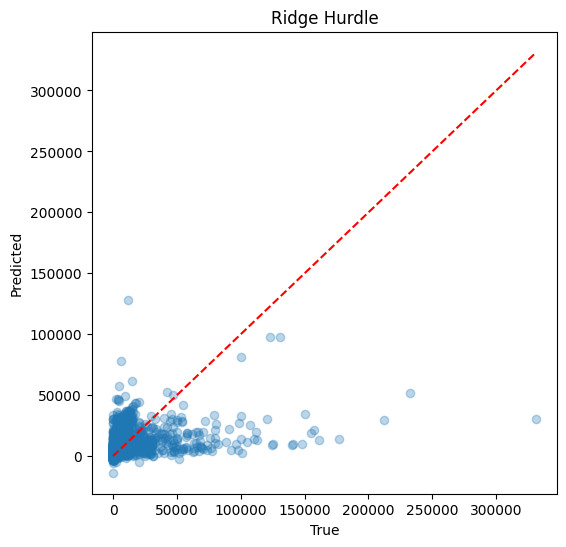

RF Hurdle Results:
MAE: 4042.726 | RMSE: 11986.598 | R²: 0.122


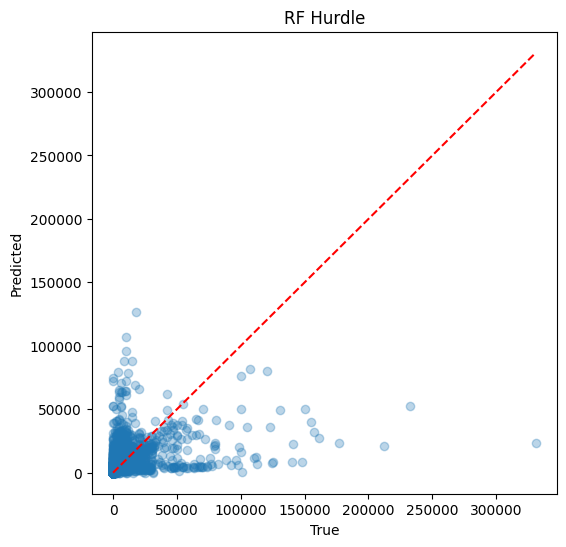

CatBoost Hurdle Results:
MAE: 4461.094 | RMSE: 11597.750 | R²: 0.178


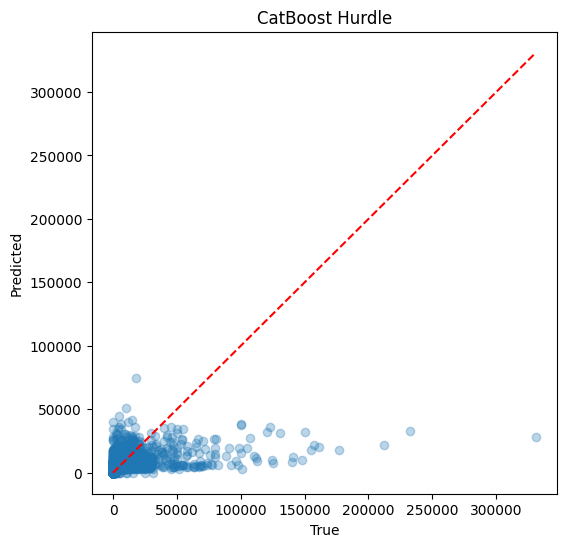

In [12]:
# ===========================
#  Evaluate Hurdle Models
# ===========================
# Ridge hurdle
y_pred_ridge_hurdle = predict_hurdle(clf, grid_ridge.best_estimator_, X_test)
print("Ridge Hurdle Results:")
regression_metrics(y_test, y_pred_ridge_hurdle)
yreal_vs_ypred(y_test, y_pred_ridge_hurdle, "Ridge Hurdle")

# RF hurdle
y_pred_rf_hurdle = predict_hurdle(clf, random_rf.best_estimator_, X_test)
print("RF Hurdle Results:")
regression_metrics(y_test, y_pred_rf_hurdle)
yreal_vs_ypred(y_test, y_pred_rf_hurdle, "RF Hurdle")

# CatBoost hurdle
y_pred_cat_hurdle = predict_hurdle(clf, random_cat.best_estimator_, X_test)
print("CatBoost Hurdle Results:")
regression_metrics(y_test, y_pred_cat_hurdle)
yreal_vs_ypred(y_test, y_pred_cat_hurdle, "CatBoost Hurdle")

In [22]:
# Classifier results
classifier_results = {
    'Accuracy': 0.914,
    'F1': 0.75,
    'ROC_AUC': 0.858
}

# Print classifier summary
print("Clasificador (Hurdle):\n")
print(f"Accuracy: {classifier_results['Accuracy']:.3f} | "
      f"F1: {classifier_results['F1']:.3f} | "
      f"ROC-AUC: {classifier_results['ROC_AUC']:.3f}\n")

# Regression results
regression_results = pd.DataFrame({
    'Modelo': ['Ridge Baseline', 'Ridge Hurdle', 'CatBoost Hurdle'],
    'MAE': [4568.59, 4389.10, 4461.09],
    'RMSE': [11873.91, 11757.94, 11597.75],
    'R²': [0.139, 0.156, 0.178]
})

# Print regression table
print("Regresor:\n")
print(regression_results.to_string(index=False))

Clasificador (Hurdle):

Accuracy: 0.914 | F1: 0.750 | ROC-AUC: 0.858

Regresor:

         Modelo     MAE     RMSE    R²
 Ridge Baseline 4568.59 11873.91 0.139
   Ridge Hurdle 4389.10 11757.94 0.156
CatBoost Hurdle 4461.09 11597.75 0.178


In [18]:
#conclutions



El enfoque hurdle divide el problema en dos tareas y cada una puede ser optimizada por separado, aumentando la precisión general. Se usó este enfoque debido a la gran cantidad de valores =0 en el target ($\sim 20\%$)

La parte de clasificación del hurdle model funciona muy bien:
Accuracy ~91%, F1 para clase positiva ~0.95, ROC-AUC ~0.86. Esto asegura que la predicción de “si ocurre el evento” es confiable antes de predecir su magnitud.

La parte de regresión (condicional al evento) mejora con respecto al baseline, especialmente usando CatBoost (R²=0.178, RMSE ~11,598). Es necesario un análisis más completo para mejorar la regresión. La mágnitud de los outliers probablemente afecta las métricas. Para mejorar las métricas se pueden considerar transformaciones del target. Divididir los datos en bins y usa clasficador en bins con regresores en cada bin  probablemente mejorará las métricas.

   ------

La clasificación confiable permite filtrar correctamente los casos en que no hay evento (pago). En general, esto puede evitar el desperdicio de recursos o decisiones basadas en predicciones irrelevantes.

La predicción condicional precisa ayuda a planificar mejor la magnitud de las acciones, como presupuestos, asignación de recursos o estimaciones de riesgo. Es necesario mejorar está parte del modelo.

En conjunto, el modelo hurdle ofrece una solución más robusta que un único modelo de regresión y permite decisiones más informadas.